## Packages and Presets

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("whitegrid")

from tqdm import tqdm

import torch
from skimpy import clean_columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from pickle import load
import shap
from torch.utils.data import DataLoader

from neural_additive_model import NAM


import sys

sys.path.append("../..")
from utils.utils import (
    set_all_seeds,
    test,
    get_n_units,
    HeartFailureDataset,
    EarlyStopping,
    set_all_seeds,
    train_and_validate,
    penalized_binary_cross_entropy,
)

import warnings
warnings.filterwarnings("ignore")

In [36]:
SEED = 123
GRID_SIZE = 10_000

TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 1_000


HIDDEN_PROFILE = [1024]
USE_EXU = False
USE_RELU_N = False
WITHIN_FEATURE_DROPOUT = 0.4
FEATURE_DROPOUT = 0.0

# number of models to train in the multiple models section
N_MODELS = 100

LEARNING_RATE = 0.003

SCHEDULER_STEP_SIZE = 10
SCHEDULER_GAMMA = 0.9

OPTIMIZER = torch.optim.Adam
CRITERION = penalized_binary_cross_entropy

OUTPUT_REGULARIZATION = 0.0058
L2_REGULARIZATION = 3.87e-5

EARLY_STOPPING_START = 60

## Loading Data and Model

In [37]:
train_df = pd.read_csv("../data/heart_failure/train_val_split.csv").pipe(
    clean_columns
)
X_train = train_df.drop(columns=["heart_disease"], axis=1)
outlier_idx = X_train.query("resting_bp == 0").index
print(f"{outlier_idx=}")
X_train = X_train.drop(outlier_idx)
y_train = train_df["heart_disease"]
y_train = y_train[X_train.index]

# create categorical variable for cholesterol level
X_train["chol_level"] = pd.cut(
    X_train["cholesterol"],
    bins=[-1, 10, 200, 240, 1000],
    labels=["imputed", "normal", "borderline", "high"],
)

outlier_idx=Index([366], dtype='int64')


We also have to load the test (X) data as they will be used later for the SHAP values:

In [38]:
test_df = pd.read_csv("../data/heart_failure/test_split.csv").pipe(clean_columns)
X_test = test_df.drop(columns=["heart_disease"], axis=1)
# create categorical variable for cholesterol
X_test["chol_level"] = pd.cut(
    X_test["cholesterol"],
    bins=[-1, 10, 200, 240, 1000],
    labels=["imputed", "normal", "borderline", "high"],
)
y_test = test_df["heart_disease"]

In [39]:
X_models_train, X_models_val, y_models_train, y_models_val = train_test_split(
    X_train,
    y_train.to_numpy(),
    test_size=0.2,
    shuffle=True,
    random_state=SEED,
    stratify=y_train.to_numpy(),
)

In [40]:
preprocessor = load(open("../models/preprocessor.pkl", "rb"))

categorical_cols = [col for col in X_train.columns if X_train.nunique()[col] < 5]
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_models_train)
X_val_preprocessed = preprocessor.transform(X_models_val)
X_test_preprocessed = preprocessor.transform(X_test)

In [41]:
set_all_seeds(SEED)
pretrained_nam = torch.load("../models/neural_additive_model.pth", map_location=DEVICE)

## Performance Metrics

In [42]:
test_dataset = HeartFailureDataset(X_test_preprocessed, y_test.to_numpy())
test_loader = DataLoader(
    test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, pin_memory=True
)


In [43]:
test_loss, test_f1_score, balanced_accuracy, model_probs, y_true = test(
    model=pretrained_nam,
    test_loader=test_loader,
    criterion=CRITERION,
    device=DEVICE,
    use_penalized_BCE=True,
    output_regularization=OUTPUT_REGULARIZATION,
    l2_regularization=L2_REGULARIZATION,
)

Test Loss: 0.4277929663658142
Test F1 Score: 0.8722466960352423
Test Balanced Accuracy: 0.8283783783783785


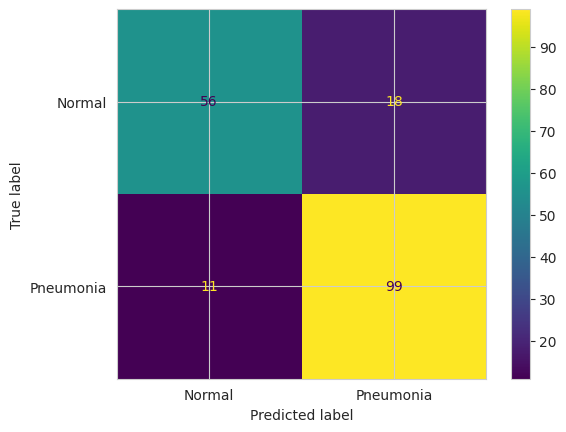

In [44]:
# Plot confusion matrix
labels = y_true
preds = model_probs.round()
cm  = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

In [45]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)

roc_auc = roc_auc_score(y_true, model_probs)


print(f"Accuracy of the model is {accuracy:.3f}")
print(f"Balanced accuracy of the model is {balanced_accuracy:.3f}")
print(f"Recall of the model is {recall:.3f}")
print(f"Precision of the model is {precision:.3f}")
print(f"F1 Score of the model is {test_f1_score:.3f}")
print(f"ROC AUC of the model is {roc_auc:.3f}")

Accuracy of the model is 0.842
Balanced accuracy of the model is 0.828
Recall of the model is 0.900
Precision of the model is 0.846
F1 Score of the model is 0.872
ROC AUC of the model is 0.894


## Shape Plots

In this section we will try to produce partial dependence plots similar to the ones used in the [original paper](https://arxiv.org/pdf/2004.13912.pdf).

In [46]:
X_train.head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,chol_level
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,high
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,high
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,borderline
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,normal
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,high


In [47]:
pd.DataFrame(X_train_preprocessed).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.288403,-2.115448,0.286261,0.726713,-0.790345,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,-1.677185,-0.670178,0.794032,1.367215,-0.790345,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.993550,-1.337226,0.674013,1.327183,0.871980,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.395232,-0.670178,-1.809447,0.806776,-0.790345,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.288403,-0.670178,-1.809447,-0.354134,0.594926,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


We can see that the first five columns in X_train_preprocessed are the numeric columns. To increase interpretability of the final plots, we will inverse transform the scales of these columns for the plots. Hence, the neural additive model will be fitted on the scaled data, but the plots will be based on the original, non scaled columns.

In [48]:
X_numeric = X_train_preprocessed[:, :5]
X_categorical = X_train_preprocessed[:, 5:]

# calculate 1st and 99th percentile for each numeric feature
percentiles = np.percentile(X_numeric, [0, 100], axis=0)
percentiles

# create one grid that will be passed as input to the model to get the logits of
# the different feature NNs and one grid to plot the logits afterwards
model_grids = []
plotting_grids = []
for i in range(X_numeric.shape[1]):
    model_grids.append(np.linspace(percentiles[0, i], percentiles[1, i], GRID_SIZE))
    plotting_grids.append(np.linspace(percentiles[0, i], percentiles[1, i], GRID_SIZE))


model_grids.append(
    np.array([[0] * (GRID_SIZE // 2) + [1] * (GRID_SIZE // 2)] * X_categorical.shape[1])
)

plotting_grids.extend([np.linspace(0, 1, GRID_SIZE)] * X_categorical.shape[1])

# model input grid
input = torch.tensor(np.row_stack(model_grids).T).float()
print(f"{input.shape=}")

# grid for plots
plotting_grids = np.row_stack(plotting_grids).T
print(f"{plotting_grids.shape=}")

input.shape=torch.Size([10000, 25])
plotting_grids.shape=(10000, 25)


In [49]:
pd.DataFrame(input.numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-2.638649,-2.893671,-1.809447,-3.036236,-2.637373,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.638136,-2.893003,-1.808969,-3.035696,-2.636616,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.637623,-2.892336,-1.808491,-3.035155,-2.635859,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.637110,-2.891669,-1.808012,-3.034615,-2.635101,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.636598,-2.891002,-1.807534,-3.034074,-2.634344,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# set all seeds for reproducibility
set_all_seeds(SEED)
# set model to eval mode to disable dropout
pretrained_nam.eval()
# get logits for each feature
feature_logits = pretrained_nam(input.to(DEVICE))[1].detach().cpu().numpy()

In [51]:
# bring back the transformed data to the original scale
plotting_grids_backtrans = (
    np.c_[
        preprocessor.named_transformers_["numeric"]
        .inverse_transform(plotting_grids[:, :5]),
        plotting_grids[:, 5:]
    ]
)

print(f"{plotting_grids_backtrans.shape=}")

X_train_backtrans = (
    np.c_[
        preprocessor.named_transformers_["numeric"]
        .inverse_transform(X_numeric),
        X_categorical
    ]
)
print(f"{X_train_backtrans.shape=}")

plotting_grids_backtrans.shape=(10000, 25)
X_train_backtrans.shape=(586, 25)


In [52]:
# get names of the transformed features
numeric_feature_names = preprocessor.named_transformers_[
    "numeric"
].get_feature_names_out()
categorical_feature_names = preprocessor.named_transformers_[
    "categorical"
].get_feature_names_out()
names = np.concatenate([numeric_feature_names, categorical_feature_names])
print(f"{names=}")

names=array(['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak', 'sex_F',
       'sex_M', 'chest_pain_type_ASY', 'chest_pain_type_ATA',
       'chest_pain_type_NAP', 'chest_pain_type_TA', 'fasting_bs_0',
       'fasting_bs_1', 'resting_ecg_LVH', 'resting_ecg_Normal',
       'resting_ecg_ST', 'exercise_angina_N', 'exercise_angina_Y',
       'st_slope_Down', 'st_slope_Flat', 'st_slope_Up',
       'chol_level_borderline', 'chol_level_high', 'chol_level_imputed',
       'chol_level_normal'], dtype=object)


We have to manually clean the names of the columns for the plots:

In [53]:
names_cleaned = [
    "Age",
    "Resting Blood Pressure",
    "Cholesterol",
    "Maximum Heart Rate",
    "Old Peak",
    "Sex: Female",
    "Sex: Male",
    "Chest Pain: Type Asymptomatic",
    "Chest Pain: Type Atypical Angina",
    "Chest Pain: Type Non-Anginal Pain",
    "Chest Pain: Type Typical Angina",
    "Fasting Blood Sugar < 120 mg/dl",
    "Fasting Blood Sugar > 120 mg/dl",
    "Resting ECG: Left Ventricular Hypertrophy",
    "Resting ECG: Normal",
    "Resting ECG: ST-T Wave Abnormality",
    "Exercise-Induced Angina: No",
    "Exercise-Induced Angina: Yes",
    "ST Slope: Downsloping",
    "ST Slope: Flat",
    "ST Slope: Upsloping",
    "Cholesterol Level: Borderline",
    "Cholesterol Level: High",
    "Cholesterol Level: Imputed",
    "Cholesterol Level: Normal"    
]

assert len(names_cleaned) == len(names)

Finally, we can plot the learned relationship between each feature and the target:

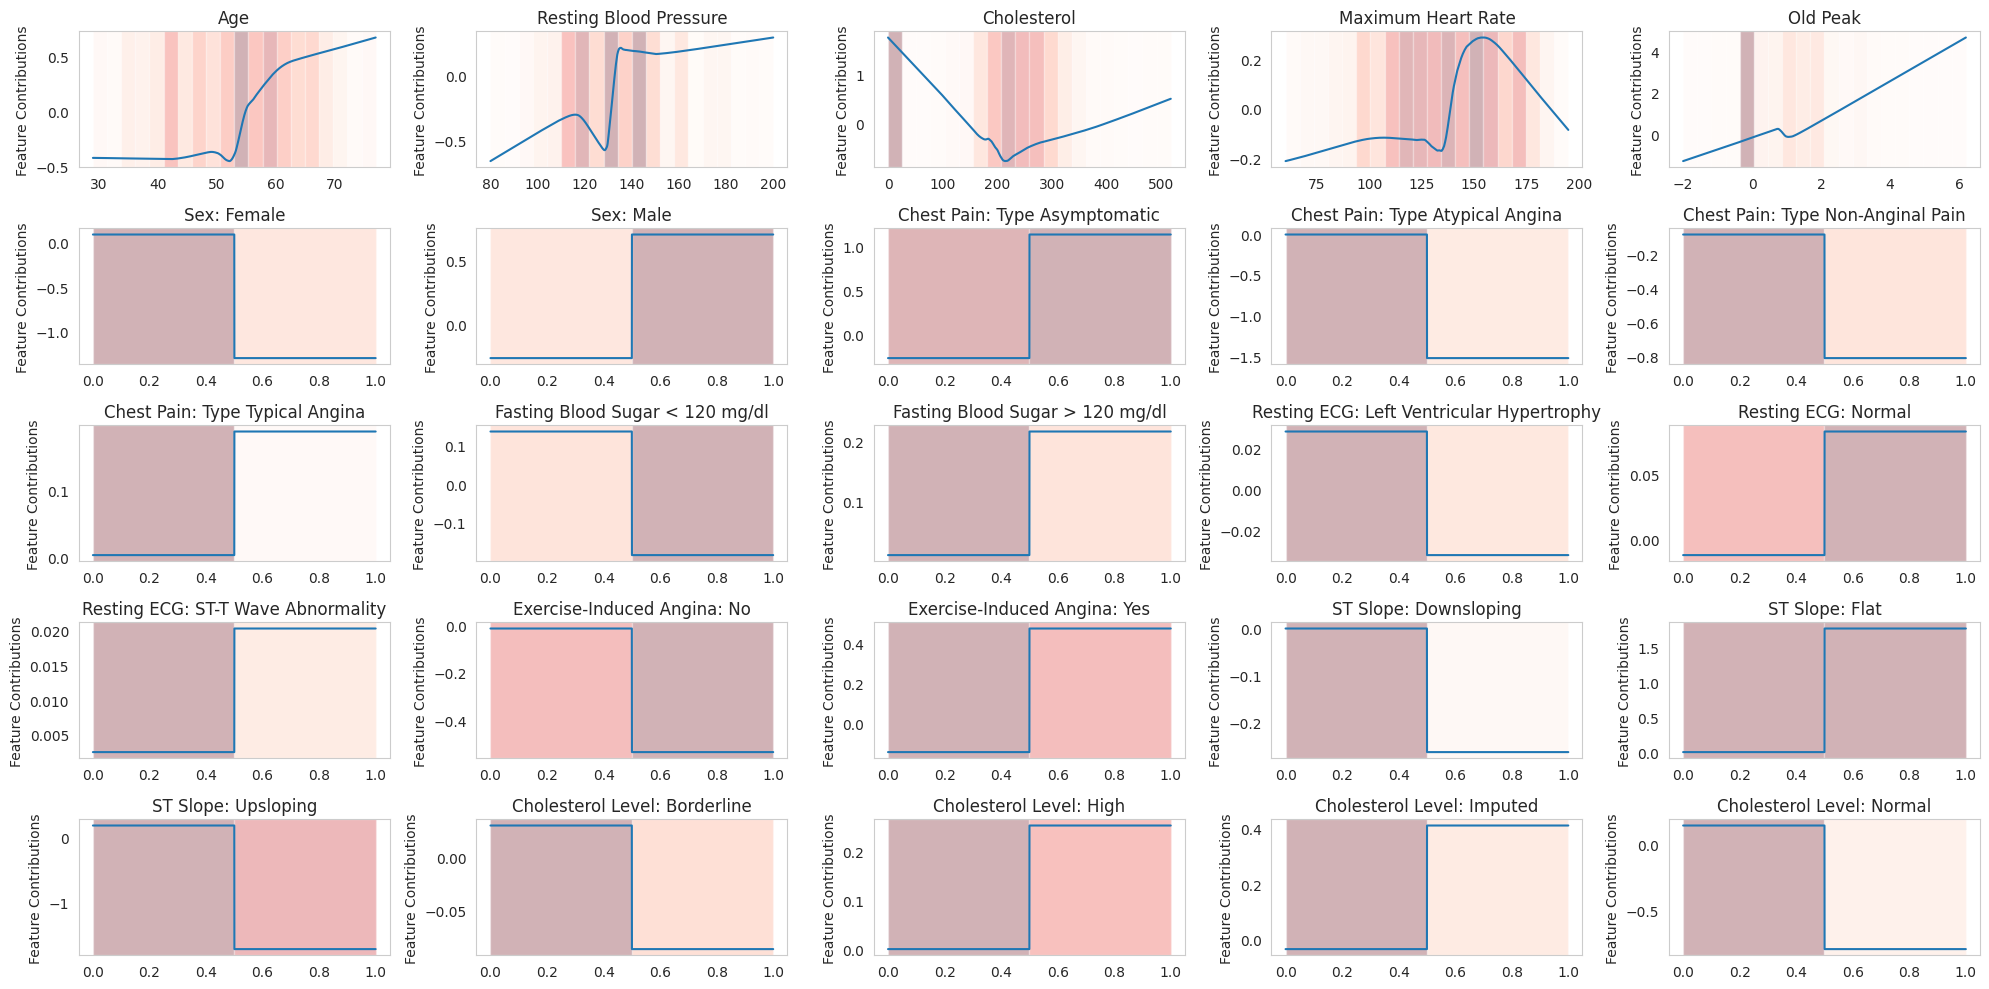

In [54]:
# plot every column vs the corresponding logits column
fig, axs = plt.subplots(5, 5, figsize=(20, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.plot(plotting_grids_backtrans[:, i], feature_logits[:, i])
    if i < 5:
        counts, bins = np.histogram(X_train_backtrans[:, i], bins=20)

        # create color gradient for counts:
        norm = plt.Normalize(0, counts.max())
        colors = plt.cm.Reds(norm(counts))
        
        # bars in the background that indicate the distribution of the variable
        for j in range(len(bins) - 1):
            ax.axvspan(xmin=bins[j], xmax=bins[j + 1], facecolor=colors[j], alpha=0.3)

    else:
        counts, bins = np.histogram(X_train_backtrans[:, i], bins=2)

        # create color gradient for counts:
        norm = plt.Normalize(0, counts.max())
        colors = plt.cm.Reds(norm(counts))
        
        # bars in the background that indicate the distribution of the variable
        for j in range(len(bins) - 1):
            ax.axvspan(xmin=bins[j], xmax=bins[j + 1], facecolor=colors[j], alpha=0.3)

    ax.set_title(f"{names_cleaned[i]}")
    ax.set_xlabel("")
    ax.set_ylabel("Feature Contributions")
    ax.grid(False)
plt.tight_layout()
plt.show()


## Multiple Models Shape Plots

As in the paper, we can do the same plots also with multiple models to get a better understanding of the uncertainty behind the logits. Thus, we proceed with the same preprosessing as in the run_nam.py script:

In [55]:
# create datasets and dataloaders
train_dataset = HeartFailureDataset(X_train_preprocessed, y_models_train)
val_dataset = HeartFailureDataset(X_val_preprocessed, y_models_val)

train_loader = DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, pin_memory=True
)

In [56]:
model_logits = []
for i in tqdm(range(N_MODELS), desc = "Training models"):
    # initialize each model with a different seed
    set_all_seeds(SEED + i)
    model = NAM(
        n_features=X_train_preprocessed.shape[1],
        in_size=get_n_units(X_train_preprocessed),
        out_size=1,
        hidden_profile=HIDDEN_PROFILE,
        use_exu=USE_EXU,
        use_relu_n=USE_RELU_N,
        within_feature_dropout=WITHIN_FEATURE_DROPOUT,
        feature_dropout=FEATURE_DROPOUT,
    ).to(DEVICE)
    
    optimizer = OPTIMIZER(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=SCHEDULER_STEP_SIZE, gamma=SCHEDULER_GAMMA
    )


    # instantiate early stopping class
    ES = EarlyStopping(
        start=EARLY_STOPPING_START,
        epsilon=1e-6,
    )

    # train the model on the training data and validate on the validation data
    # the best model is saved in the best_model_path using the ES object from above
    train_and_validate(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=CRITERION,
        n_epochs=N_EPOCHS,
        ES=ES,
        scheduler=scheduler,
        device=DEVICE,
        use_penalized_BCE=True,
        output_regularization=OUTPUT_REGULARIZATION,
        l2_regularization=L2_REGULARIZATION,
    )
    
    # get logits for this model
    model_logits.append(model(input.to(DEVICE))[1].detach().cpu().numpy())
model_logits = np.stack(model_logits)

Training models: 100%|██████████| 100/100 [22:29<00:00, 13.49s/it]


In [57]:
# for each feature and grid point calculate the mean of the logits of the different models
mean_logits = model_logits.mean(axis=0)

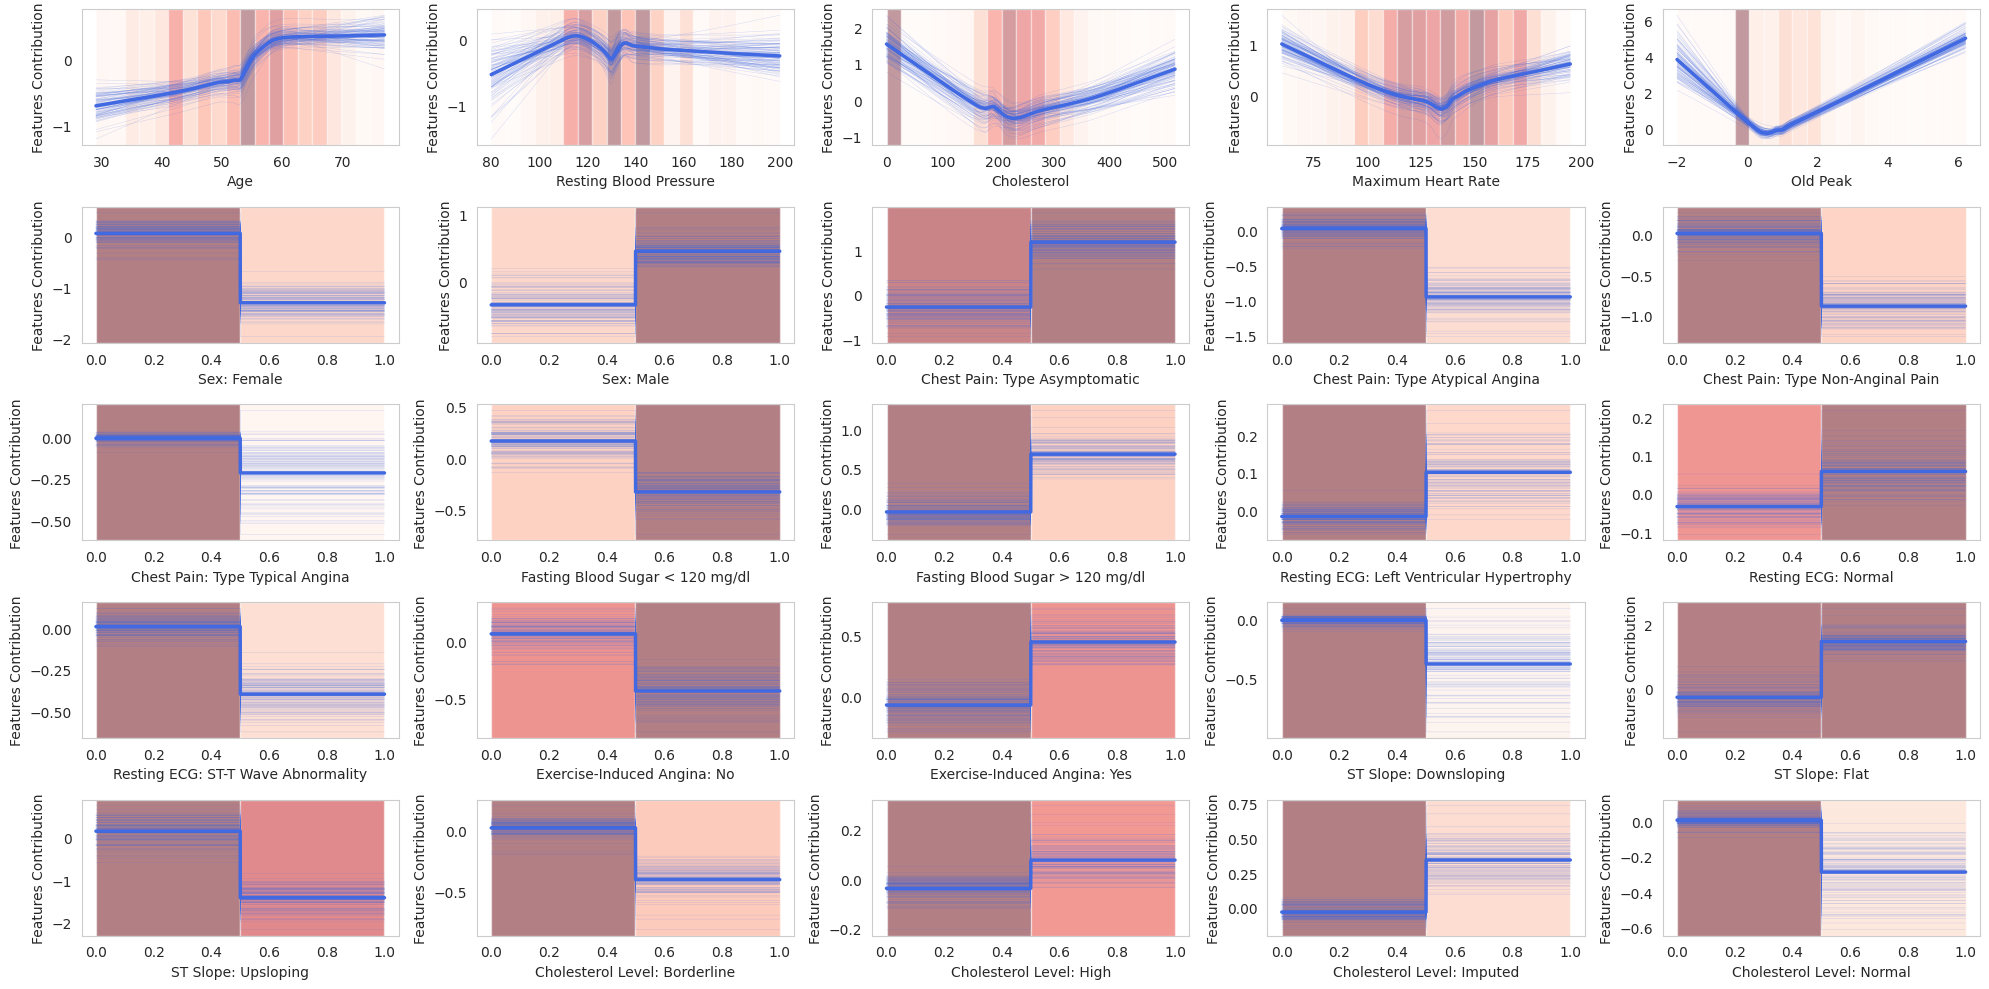

In [92]:
# plot every column vs the corresponding logits column
fig, axs = plt.subplots(5, 5, figsize=(20, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    # plot mean logits of all models
    ax.plot(plotting_grids_backtrans[:, i], mean_logits[:, i], alpha=1, linewidth=2.5, color = "royalblue")
    for model_nr, logits in enumerate(model_logits):
        ax.plot(plotting_grids_backtrans[:, i], logits[:, i], alpha=0.25, linewidth=0.3, color = "royalblue")
        if i < 5 and model_nr == 0:
            counts, bins = np.histogram(X_train_backtrans[:, i], bins=20)

            # create color gradient for counts:
            # https://matplotlib.org/stable/users/explain/colors/colormapnorms.html
            norm = plt.Normalize(0, counts.max())
            colors = plt.cm.Reds(norm(counts))

            # bars in the background that indicate the distribution of the variable
            for j in range(len(bins) - 1):
                ax.axvspan(xmin=bins[j], xmax=bins[j + 1],  alpha=0.4, facecolor=colors[j])

        elif i >= 5 and model_nr == 0:
            counts, bins = np.histogram(X_train_backtrans[:, i], bins=2)

            # create color gradient for counts:
            # https://matplotlib.org/stable/users/explain/colors/colormapnorms.html
            norm = plt.Normalize(0, counts.max())
            colors = plt.cm.Reds(norm(counts))

            # bars in the background that indicate the distribution of the variable
            for j in range(len(bins) - 1):
                ax.axvspan(xmin=bins[j], xmax=bins[j + 1], facecolor=colors[j], alpha=0.5)

        #ax.set_title("")
        ax.set_xlabel(f"{names_cleaned[i]}")
        ax.set_ylabel("Features Contribution")
        ax.grid(False)
plt.tight_layout()
plt.show()

fig.savefig("nam_shapes.png")

array([-1.21411768, -0.60705884,  0.        ,  0.50782239,  1.01564478])

## Feature Importance

All of the code in this section is copied from [this GitHub repository](https://github.com/AmrMKayid/nam/blob/main/nam/utils/graphing.py) and slightly modified to fit our data.

In [59]:
train_dataset.X.shape

torch.Size([586, 25])

In [60]:
# get unique features:
single_features = np.split(train_dataset.X.numpy(), train_dataset.X.shape[1], axis=1)
unique_features = [np.unique(feature, axis = 0) for feature in single_features]


In [61]:
pretrained_nam.eval()

# calculate contribrution of each feature
feature_contributions = []
for i, feature in enumerate(unique_features):
    feature = torch.tensor(feature).float().to(DEVICE)
    feat_contribution = pretrained_nam.feature_nets[i](feature).cpu().detach().numpy().squeeze()
    feature_contributions.append(feat_contribution)

In [62]:
# Calculate the mean prediction
avg_hist_data = {col: contributions for col, contributions in zip(names_cleaned, feature_contributions)}
all_indices, mean_pred = {}, {}


for col in names_cleaned:
    mean_pred[col] = np.mean([avg_hist_data[col]])

mean_pred, avg_hist_data

({'Age': -0.003258445,
  'Resting Blood Pressure': -0.08837671,
  'Cholesterol': -0.35699463,
  'Maximum Heart Rate': 0.0016641589,
  'Old Peak': 0.75002384,
  'Sex: Female': -0.6024874,
  'Sex: Male': 0.21800792,
  'Chest Pain: Type Asymptomatic': 0.43127525,
  'Chest Pain: Type Atypical Angina': -0.76126,
  'Chest Pain: Type Non-Anginal Pain': -0.44647068,
  'Chest Pain: Type Typical Angina': 0.09557952,
  'Fasting Blood Sugar < 120 mg/dl': -0.023359314,
  'Fasting Blood Sugar > 120 mg/dl': 0.11369064,
  'Resting ECG: Left Ventricular Hypertrophy': -0.001826996,
  'Resting ECG: Normal': 0.035656214,
  'Resting ECG: ST-T Wave Abnormality': 0.011400257,
  'Exercise-Induced Angina: No': -0.27424523,
  'Exercise-Induced Angina: Yes': 0.16359557,
  'ST Slope: Downsloping': -0.1308637,
  'ST Slope: Flat': 0.8926067,
  'ST Slope: Upsloping': -0.7683426,
  'Cholesterol Level: Borderline': -0.028127488,
  'Cholesterol Level: High': 0.12725963,
  'Cholesterol Level: Imputed': 0.18858969,
  'Ch

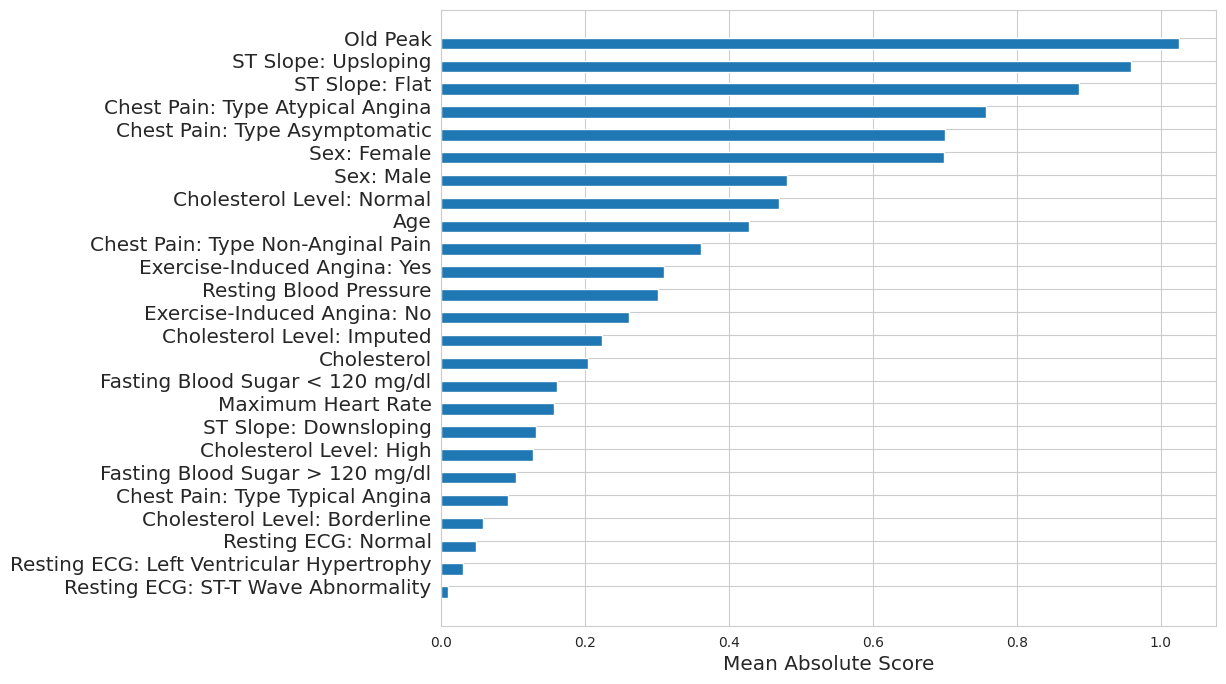

In [63]:
# compute mean feature importance
def compute_mean_feature_importance(mean_pred, avg_hist_data):
    mean_abs_score = {}
    for k in avg_hist_data:
        try:
            mean_abs_score[k] = np.mean(np.abs(avg_hist_data[k] - mean_pred[k])) 
        except:
            continue
    x1, x2 = zip(*mean_abs_score.items())
    return x1, x2

x1, x2 = compute_mean_feature_importance(mean_pred, avg_hist_data)


# plot mean feature importance
cols = names_cleaned
ind = np.arange(len(x1))
x1_indices = np.argsort(x2)

cols_here = [cols[i] for i in x1_indices]
x2_here = [x2[i] for i in x1_indices]

plt.figure(figsize=(10, 8))
plt.barh(ind, x2_here, 0.5, label='NAMs')
plt.yticks(ind + 0.5 / 2, cols_here, fontsize='x-large')
plt.xlabel('Mean Absolute Score', fontsize='x-large')
#plt.title(f'Overall Feature Importance NAM', fontsize='x-large')

plt.savefig("nam_feature_importances.pdf",format = "pdf", bbox_inches = "tight")
plt.show()

We can see that Old Peak, the direction of the ST slope, the chest pain type and the gender appears to play a significant role in the prediction of the model. Interestingly and contrary to our initial expectations, the cholesterol level appears to only play a marginal role in these predictions.

## SHAP Values

Since our model returns two outputs but the DeepExplainer only expects one, we will first have to write a class that only returns the first output of the model (and reshape it). We will then use this class to calculate the SHAP values:

In [64]:
class NAM_Summed_Logits(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # have to add a dimension since explainer did not work otherwise
        return self.model(x)[0].unsqueeze(-1)

In [65]:
model_summed_logits = NAM_Summed_Logits(model)

train_x = torch.tensor(X_train_preprocessed).float().to(DEVICE)
test_x = torch.tensor(X_test_preprocessed).float().to(DEVICE)

explainer = shap.DeepExplainer(
    model_summed_logits, train_x
)

shap_values = explainer.shap_values(test_x)

In [66]:
print(f"{shap_values.shape=}")

shap_values.shape=(184, 25, 1)


Note that the SHAP values for some reason have a third dimension. Thus, we will have to reshape the shap_values array to avoid errors in the plotting function.

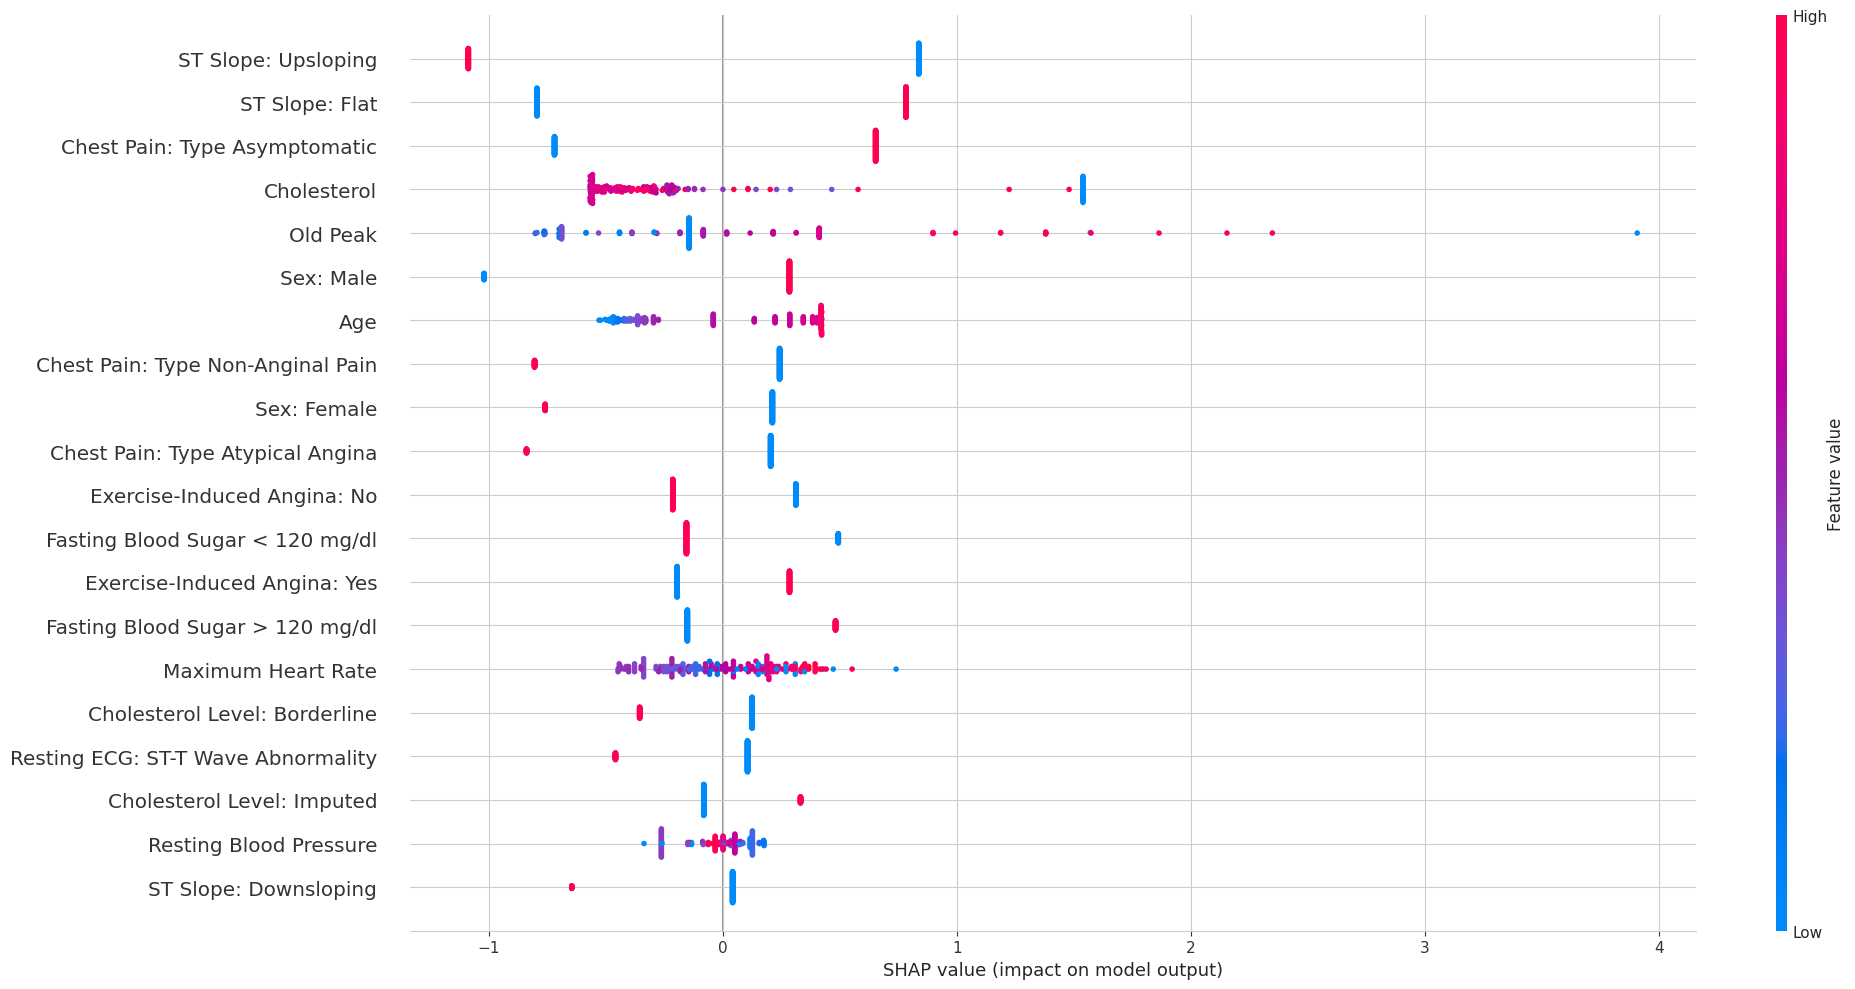

In [80]:
# create dataframe for plotting
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=names_cleaned)

plt.figure()
# plt.suptitle("SHAP Feature Importance Summary", fontsize=15)
shap.summary_plot(
    shap_values.reshape(-1, X_test_preprocessed_df.shape[1]),
    X_test_preprocessed_df,
    plot_type="dot",
    plot_size=[20, 10],
    show=False
)
plt.yticks(fontsize="x-large")
plt.savefig("nam_shap_beeswarm.png",format = "png", bbox_inches = "tight")

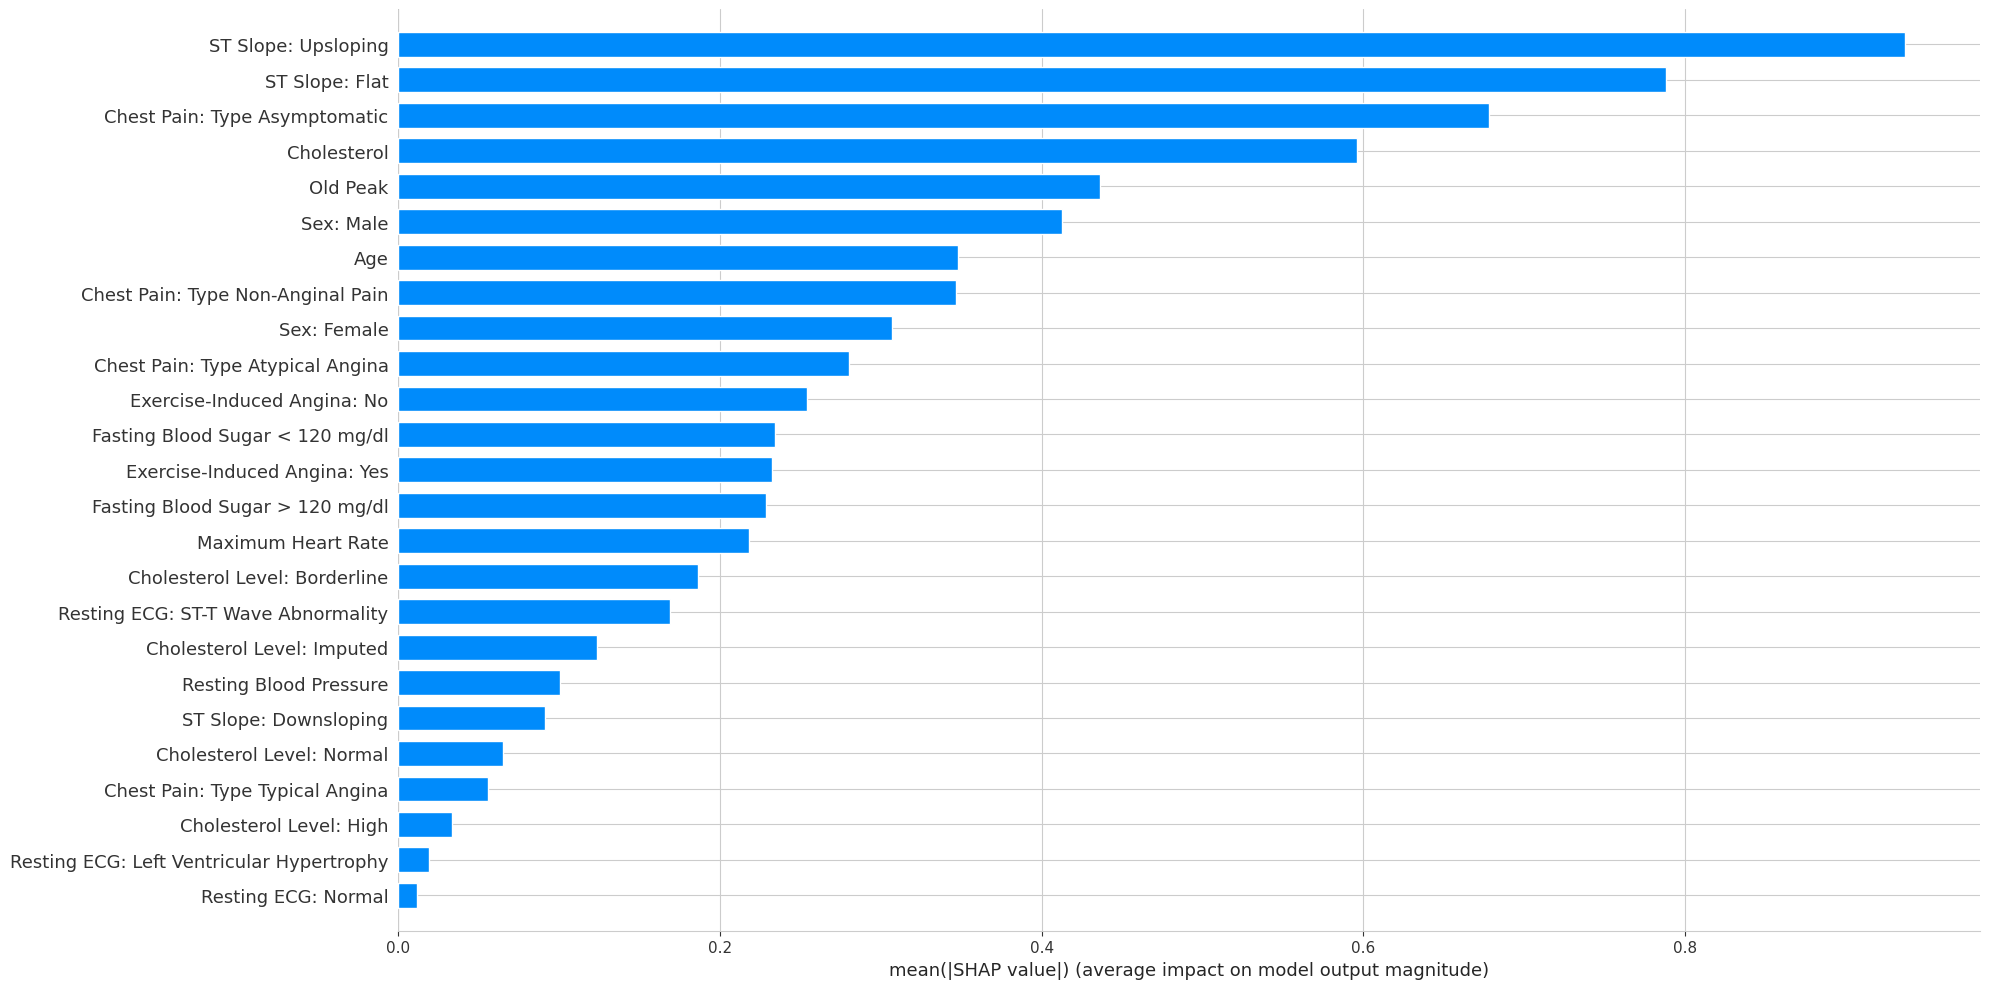

In [68]:
shap.summary_plot(
    shap_values.reshape(-1, X_test_preprocessed_df.shape[1]),
    X_test_preprocessed_df,
    plot_type="bar",
    plot_size=[20, 10],
    max_display=25, # show all features
    show=False
)

plt.savefig("nam_shap_bar.pdf",format = "pdf")

Overall, the plot looks similar as to the feature importance plot above i.e. different directions of the ST slope, old peak and gender being the most important features. However, for SHAP values, the Cholesterol level appears to play a more important role.